In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

import HH4b.utils as utils 
import HH4b.plotting as plotting
import postprocessing

import matplotlib.pyplot as plt
import mplhep as hep

/Users/cmantill/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
#Load your dataset
samples = {
    "qcd": [
        "QCD_HT-200to400",
        # "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
        "QCD_HT-1000to1200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
    ],
    "ttbar": [
        "TTto4Q",
        "TTtoLNu2Q",
    ],  
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
    "vbfhh4b": [
        "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
    ],
    "vhbb": [
        "ZH_Hto2B_Zto2Q_M-125",
        "WplusH_Hto2B_Wto2Q_M-125",
        "WminusH_Hto2B_Wto2Q_M-125"
    ]
}

MAIN_DIR = "../../../"
year = "2022EE"
dir_name = "24Jan18_v12"
# path_to_dir = f"/eos/uscms/store/user/dprim7/bbbb/skimmer/{dir_name}/"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

# columns to load                                                                                                                                                                                                                                     
load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("ak8FatJetPt", 2),
    ("ak8FatJetEta", 2),
    ("ak8FatJetPhi", 2),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
	("ak8FatJetPNetXbb", 2),    
    ("ak8FatJetTau3OverTau2", 2),                                                                                                                                                                                                              
]
# reformat into ("column name", "idx") format for reading multiindex columns                                                                                                                                                                          
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

filters = [
    [
        ("('ak8FatJetMsd', '0')", "<=", 250),
        ("('ak8FatJetMsd', '1')", "<=", 250),    
        ("('MET_pt', '0')", "<=", 1000),            
    ]
]

events_dict = {}
for input_dir, samples in dirs.items():
   
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns_mc=columns),
    }


print("Keys:")
print(events_dict.keys())
samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(keys_loaded)


Loading QCD_HT-2000
Loading QCD_HT-800to1000
Loading QCD_HT-600to800
Loading QCD_HT-1500to2000
Loading QCD_HT-200to400
Loading QCD_HT-1000to1200
Loading QCD_HT-1200to1500
Loading TTtoLNu2Q
Loading TTto4Q
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loading VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8
Loading WplusH_Hto2B_Wto2Q_M-125
Loading WminusH_Hto2B_Wto2Q_M-125
Loading ZH_Hto2B_Zto2Q_M-125
Keys:
dict_keys(['qcd', 'ttbar', 'hh4b', 'vbfhh4b', 'vhbb'])
[('weight', 0), ('MET_pt', 0), ('nFatJets', 0), ('ak8FatJetPt', 0), ('ak8FatJetPt', 1), ('ak8FatJetEta', 0), ('ak8FatJetEta', 1), ('ak8FatJetPhi', 0), ('ak8FatJetPhi', 1), ('ak8FatJetMsd', 0), ('ak8FatJetMsd', 1), ('ak8FatJetPNetMass', 0), ('ak8FatJetPNetMass', 1), ('ak8FatJetPNetXbb', 0), ('ak8FatJetPNetXbb', 1), ('ak8FatJetTau3OverTau2', 0), ('ak8FatJetTau3OverTau2', 1), ('weight_nonorm', '')]


The h candidates are the first two fatjets (ordered by Xbb):

In [4]:
# this mask assumes that only two jets are loaded and the 3rd jet is not relevant
# TODO: sort jets in skimmer
bb_masks = postprocessing.bb_assignment(events_dict)

events_dict_bdt = {}

for key, events in events_dict.items():
    # all the features that start with "bb" will apply this mask
    bb_mask = bb_masks[key]

    # for feat in ["Pt","Eta","Phi","PNetMass"]:
    #    for i in range(2):
    #         events[f"bb{i}FatJet{feat}"] = utils.get_feat(events, f"bb{i}FatJet{feat}", bb_masks[key])

    # this function will take the bb_mask into account automatically
    h1 = utils.make_vector(events, "bb0FatJet", bb_mask=bb_mask, mstring="PNetMass")
    h2 = utils.make_vector(events, "bb1FatJet", bb_mask=bb_mask, mstring="PNetMass")

    # dihiggs candidate object
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame({
        # dihiggs system
        "HHlogPt": np.log(hh.pt),
        'HHeta' : hh.eta,
        'HHmass' : hh.mass,
        # met in the event
        'MET' :  events.MET_pt[0],  
        # fatjet tau32
        'H1T32' : utils.get_feat(events, "bb0FatJetTau3OverTau2", bb_mask),
        'H2T32' : utils.get_feat(events, "bb1FatJetTau3OverTau2", bb_mask),
        # fatjet mass (not H2)
        'H1Msd' : utils.get_feat(events, "bb0FatJetMsd", bb_mask),
        'H1Mass' : h1.mass,
        # fatjet kinematics
        'H1logPt' : np.log(h1.pt),
        'H2logPt' : np.log(h2.pt),
        'H1eta' : h1.eta,
        'H2eta' : h2.eta,
        'H1_dRH2': h1.deltaR(h2),
        'H1_dPhiH2': h1.deltaphi(h2),
        # xbb
        'H1Xbb': utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask),
        # ratios
        'H1Pt_HHmass' : h1.pt/hh.mass,
        'H2Pt_HHmass' : h2.pt/hh.mass,
        'H1Pt/H2Pt' : h1.pt/h2.pt,
        # --- additional features to consider? -----
        # H2Msd
        # number of fatjets in the event
        # add VBF jet information?
        # cos(theta_star)
    })

    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    events_dict_bdt[key] = df


Now we plot the BDT variables

In [5]:
num_rows = len(events_dict_bdt["hh4b"].columns)

fig, axes = plt.subplots(num_rows, 1, figsize=(8,4*num_rows))
for i, col in enumerate(events_dict_bdt["hh4b"].columns):
    for key,events in events_dict_bdt.items():
        axes[i].hist(events[col].dropna(), bins=50, alpha=0.3, density=True, label=key)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Events')
    axes[i].legend(fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
events = pd.concat([
        events_dict_bdt["hh4b"], 
        events_dict_bdt["qcd"], 
        events_dict_bdt["ttbar"]
    ], 
    keys=['hh4b', 'qcd', 'ttbar']
)
events['target'] = 0  # Default to 0 (background)
events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)

# Define target
target = events['target']

# load features into pandas df
features = events
features.drop(columns=["target"], inplace=True)


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_66782/1874206586.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)


In [7]:
features

HHlogPt     HHeta       HHmass         MET     H1T32     H2T32  \
hh4b  0       4.632153  3.973541   883.957431   14.485280  0.729436  0.842821   
      1       4.349322  2.974594   673.433217   53.304462  0.865532  0.875998   
      2       4.302091 -2.962058   952.708589   77.265930  0.729148  0.871760   
      3       3.900320  3.954343   942.055753   39.738060  0.772727  0.684466   
      4       4.387641 -2.907199   883.966115   48.133133  0.648663  0.741030   
...                ...       ...          ...         ...       ...       ...   
ttbar 417228  3.243053  3.091482  1045.050555   66.099670  0.861678  0.810172   
      417229  1.411634 -5.463628   849.381551    7.393680  0.661259  0.477389   
      417230  4.461476  3.664649   710.384170  115.861946  0.835227  0.405778   
      417231  3.906111  3.180334   962.399386   45.301205  0.910557  0.614952   
      417232  2.858197 -5.263605   755.478662   22.816124  0.827087  0.756595   

                  H1Msd      H1Mass   H1logPt   H2logPt     H1eta     H2eta  \
hh4b  0       143.00000  156.621094  5.999735  5.915801  2.316895  1.397949   
      1       106.43750  129.062317  5.802908  5.714735  1.069336  0.943115   
      2       117.18750  119.982849  5.912812  5.927210 -1.369385 -0.085449   
      3       124.43750  130.065674  5.885878  6.013823  1.751221  0.645508   
      4       128.00000  123.169922  6.056931  6.056183 -0.619995 -0.922729   
...                 ...         ...       ...       ...       ...       ...   
ttbar 417228  128.00000  148.737610  5.717284  5.765458 -0.812378  1.322754   
      417229  150.00000  149.805420  5.947884  5.958538 -0.596680 -0.589722   
      417230   61.84375   88.264160  5.721290  5.881342  1.716309  1.617920   
      417231  155.87500  166.596680  6.038628  6.134878  0.787109  0.482666   
      417232  139.75000  143.831543  5.819759  5.771991 -1.997314 -1.165527   

               H1_dRH2  H1_dPhiH2     H1Xbb  H1Pt_HHmass  H2Pt_HHmass  \
hh4b  0       3.031533   2.888898  0.994141     0.456268     0.419535   
      1       2.916045   2.913312  0.934082     0.491900     0.450384   
      2       3.211320   2.943481  0.965332     0.388098     0.393726   
      3       3.317295  -3.127594  0.992676     0.382057     0.434204   
      4       2.968341   2.952863  0.994141     0.483121     0.482760   
...                ...        ...       ...          ...          ...   
ttbar 417228  3.743543   3.074951  0.876953     0.290970     0.305330   
      417229  3.141365   3.141357  0.800781     0.450848     0.455677   
      417230  2.935713   2.934064  0.896973     0.429765     0.504361   
      417231  3.097499   3.082502  0.846191     0.435700     0.479721   
      417232  3.227684  -3.118665  0.878906     0.445930     0.425130   

              H1Pt/H2Pt  
hh4b  0        1.087557  
      1        1.092178  
      2        0.985705  
      3        0.879902  
      4        1.000749  
...                 ...  
ttbar 417228   0.952968  
      417229   0.989403  
      417230   0.852099  
      417231   0.908237  
      417232   1.048927  

[5062128 rows x 18 columns]

In [8]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators= 196,
    max_depth= 17,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)

# Train the model 
bdt_model.fit(X_train, y_train)

# Save the model
model_file = 'boostedBDT.json'
bdt_model.save_model(model_file)

KeyboardInterrupt: 

In [ ]:
#determine importance of the features
importances = bdt_model.feature_importances_

feature_names = events.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")


target: 1.000
HHmass: 0.000
H1Msd: 0.000
H1Mass: 0.000
H1Xbb: 0.000
H2logPt: 0.000
H1logPt: 0.000
HHlogPt: 0.000
HHeta: 0.000
MET: 0.000
H1T32: 0.000
H2T32: 0.000
H1eta: 0.000
H2eta: 0.000
H1_dRH2: 0.000
H1_dPhiH2: 0.000
H1Pt_HHmass: 0.000
H2Pt_HHmass: 0.000
H1Pt/H2Pt: 0.000


In [ ]:
# Make predictions
predictions = bdt_model.predict(X_test)
probabilities = bdt_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

In [ ]:
# plot scores
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

In [ ]:
y_scores

array([3.4623019e-07, 4.6394962e-07, 3.4623019e-07, ..., 4.6394962e-07,
       2.6703796e-07, 2.0559412e-07], dtype=float32)

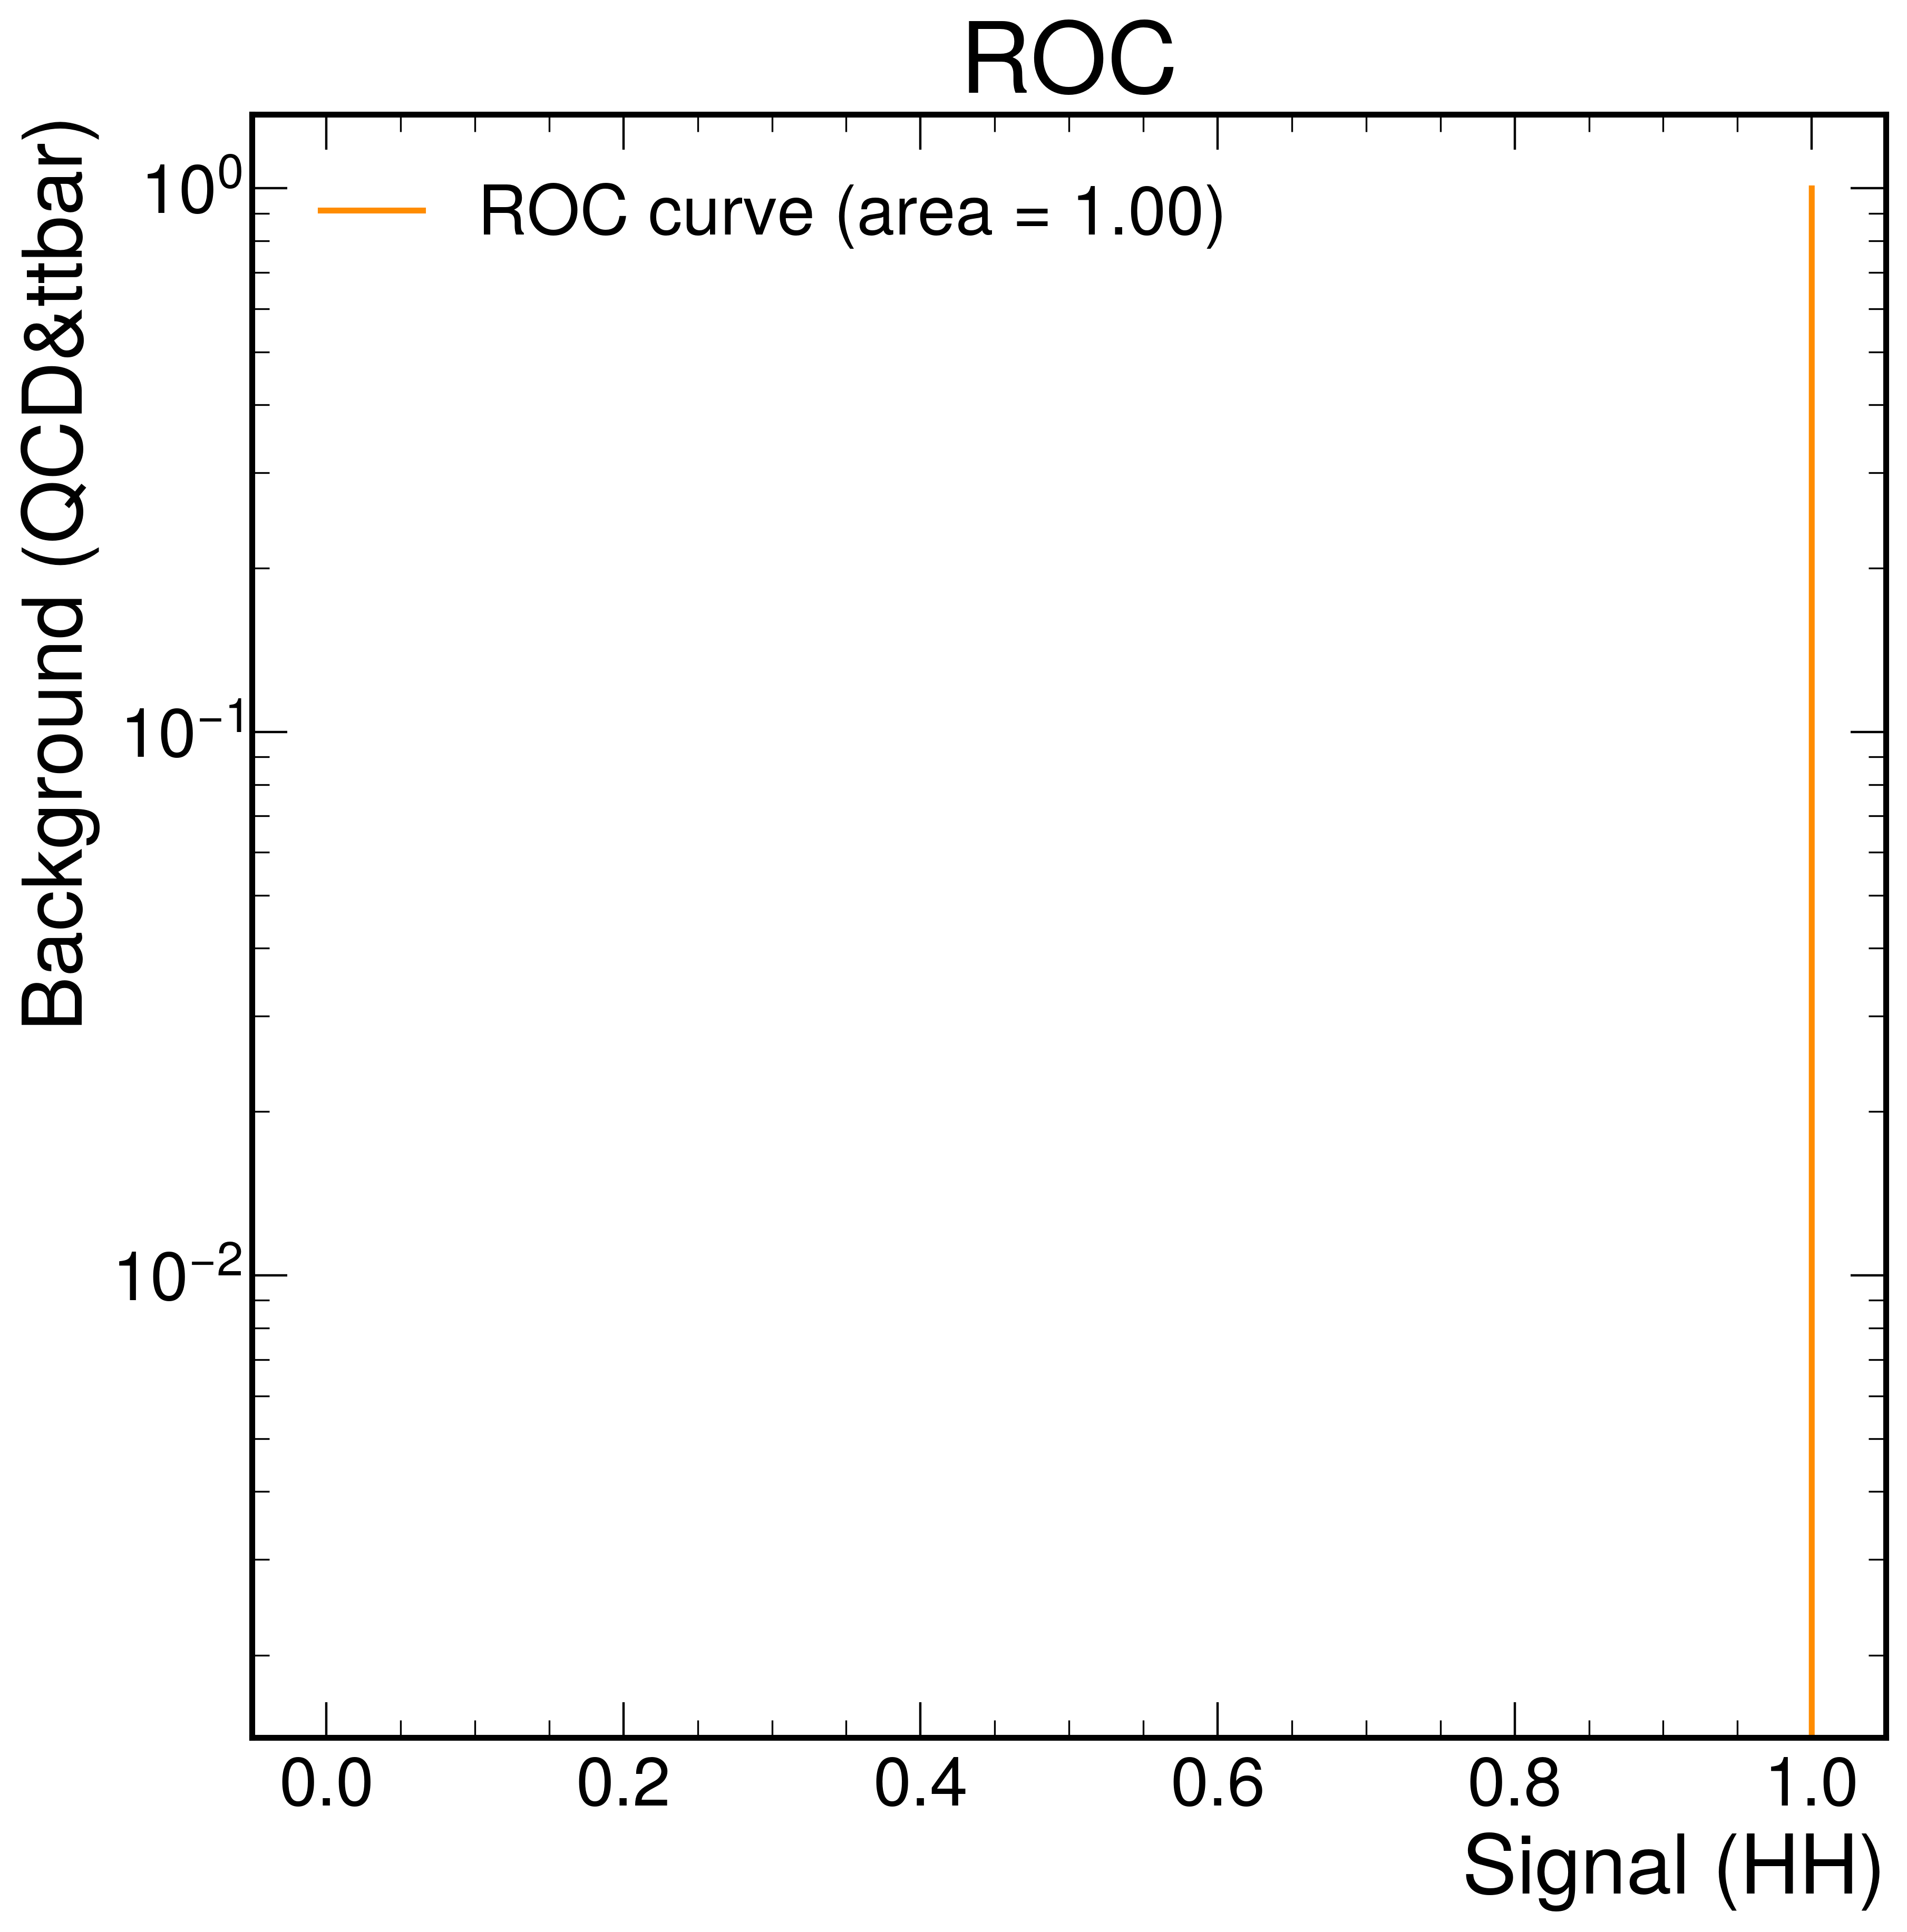

In [ ]:
# Plottting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('Signal (HH)')
plt.ylabel('Background (QCD&ttbar)')
plt.title('ROC')
plt.legend(loc="upper left")
plt.yscale('log')
plt.savefig(f'{MAIN_DIR}/../data/boosted-bdt/ROC_BDT.png')
plt.show()

In [ ]:
hh4b_scores = bdt_model.predict_proba(X_test.loc['hh4b'])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc['qcd'])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc['ttbar'])[:, 1]

/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/uscms_data/d3/dprim7/mambaforge/envs/hh4b/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

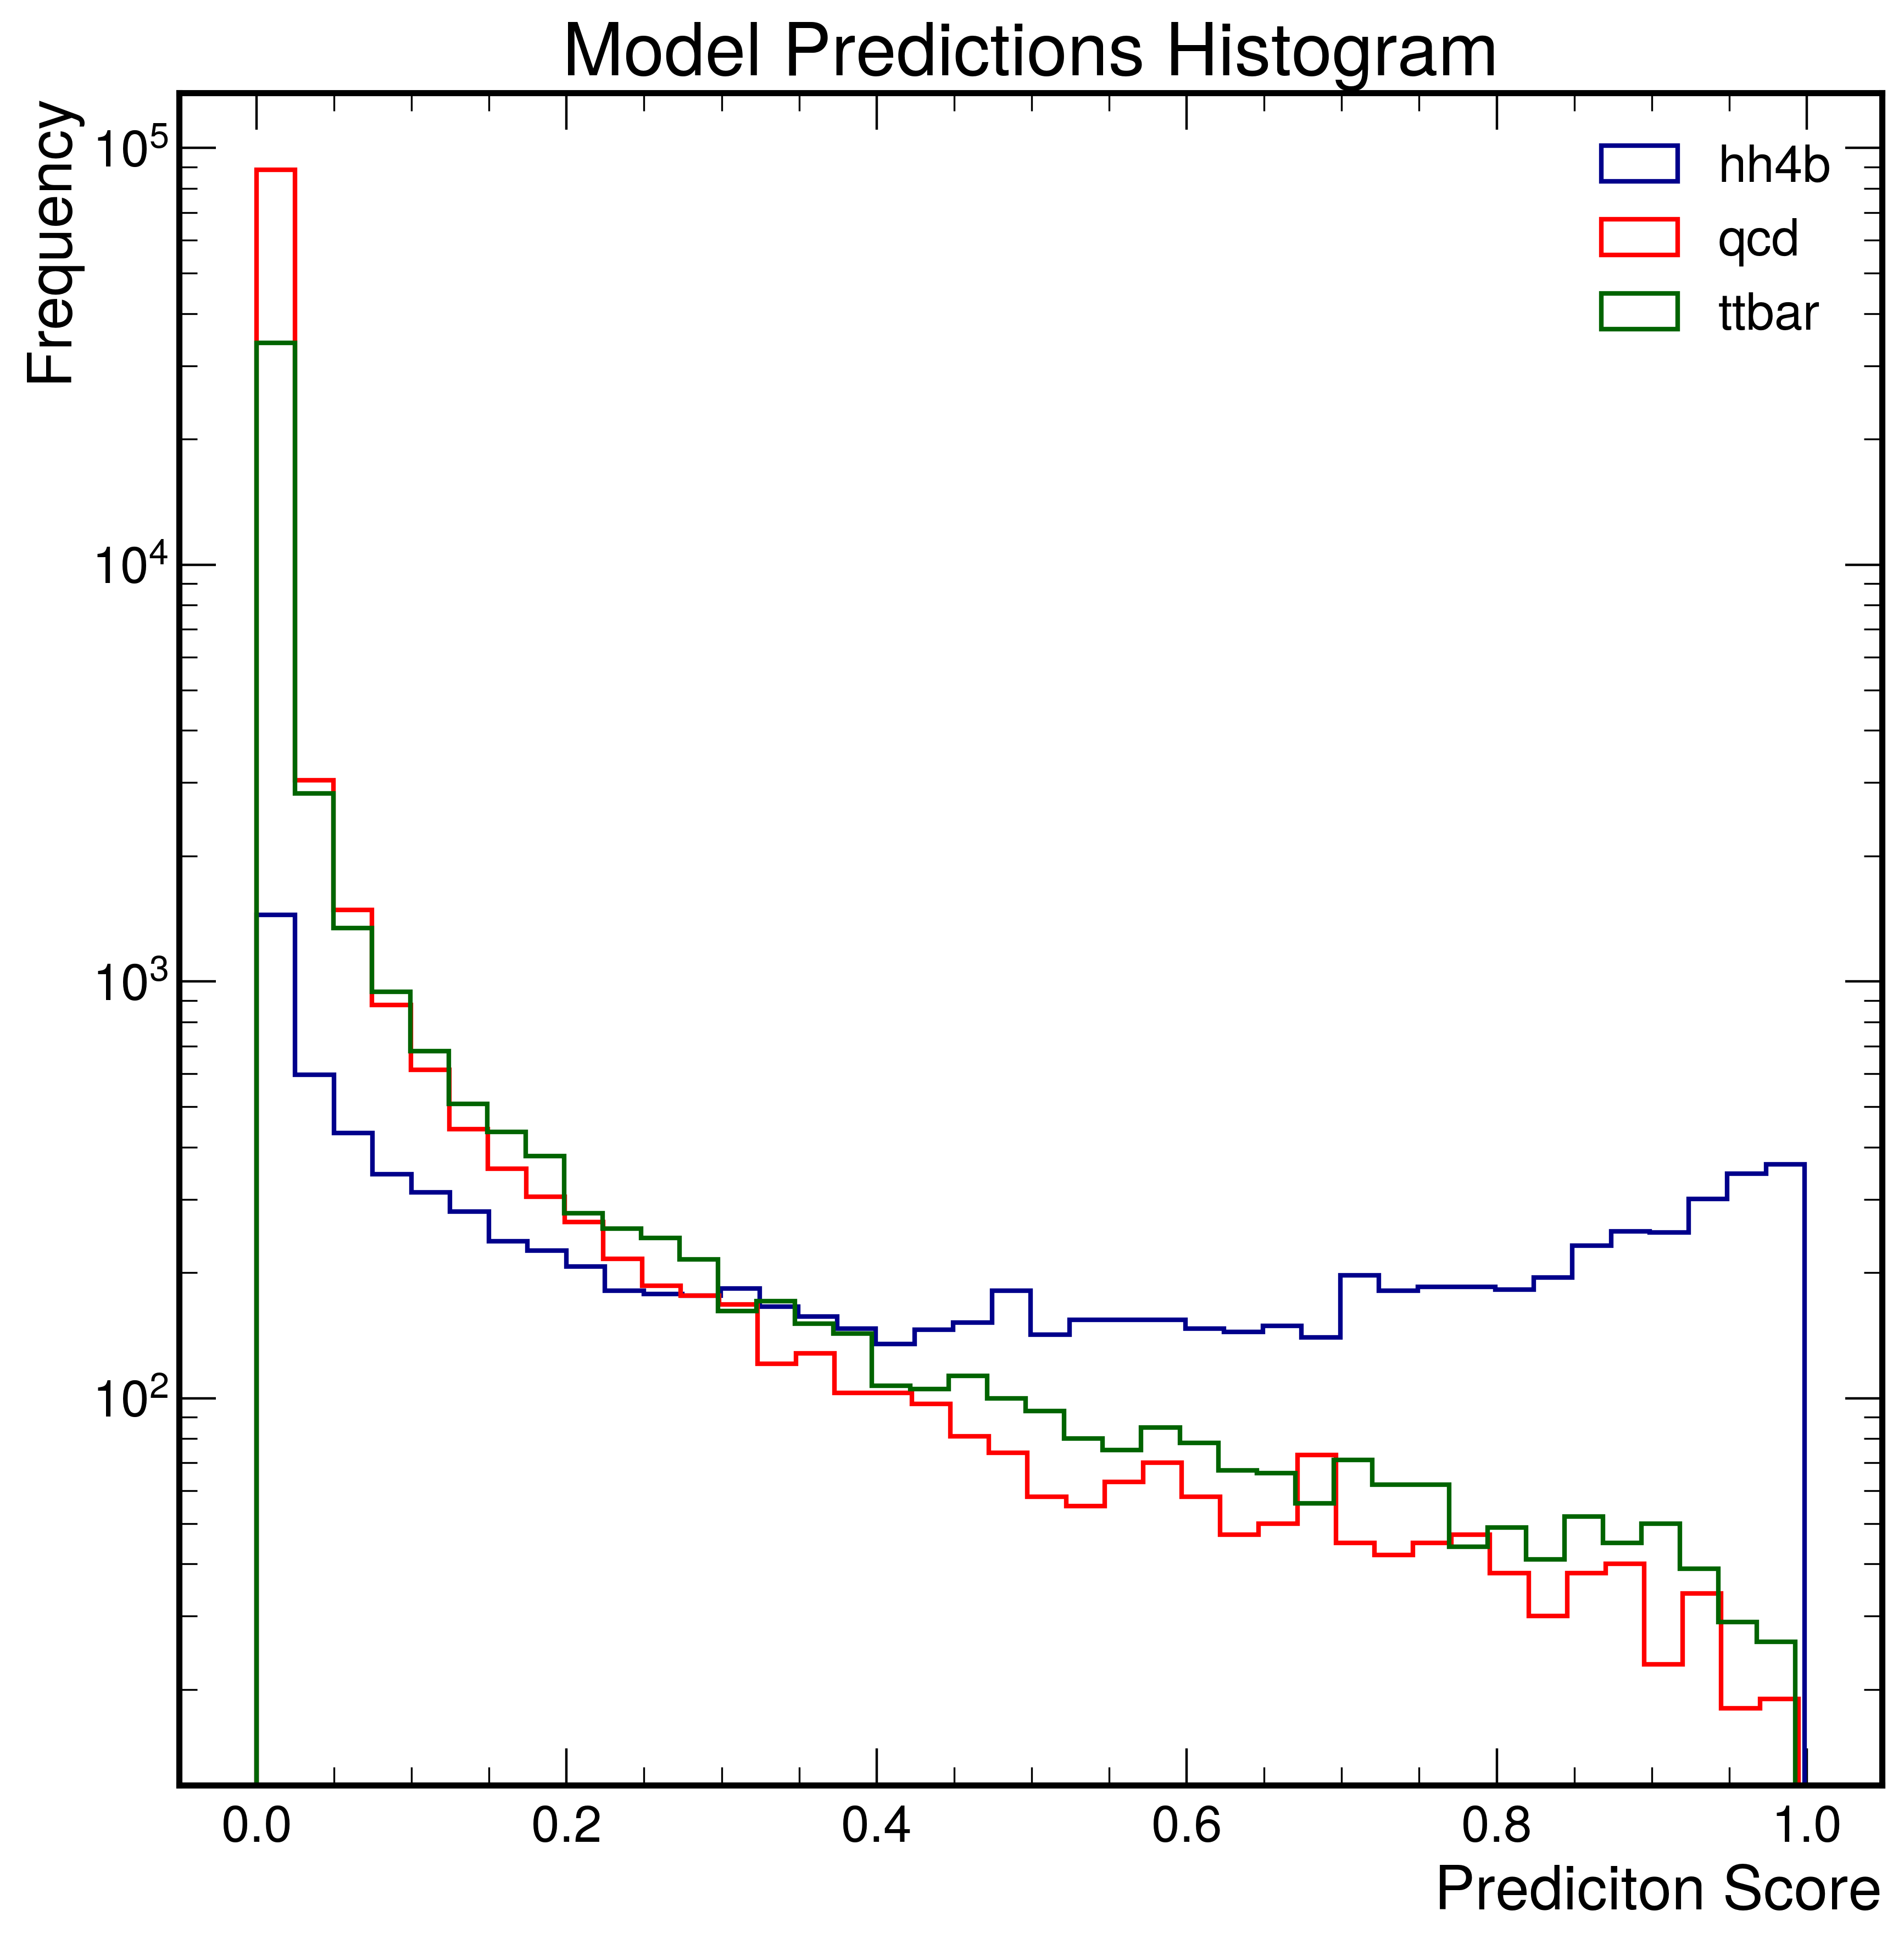

In [ ]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(qcd_scores, bins=40, histtype='step', linewidth=1.5, color='red')
plt.hist(ttbar_scores, bins=40, histtype='step', linewidth=1.5, color='darkgreen')
plt.legend(['hh4b', 'qcd', 'ttbar'])
plt.ylabel('Frequency')
plt.xlabel('Prediction Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()


Next steps:
- Plot h1 and h2 mass before and after a BDT score cut, e.g. score > 0.8, and score > 0.9.
- Perform inference on vbfhh4b sample and vhbb sample as well and show score distribution.